In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda")

In [3]:
mnist_train = torchvision.datasets.MNIST(root='~/test/Datasets/MNIST',train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='~/test/Datasets/MNIST',train=False, download=True, transform=transforms.ToTensor())

In [4]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,shuffle=True, num_workers=2)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,shuffle=False, num_workers=2)

In [5]:
num_inputs,num_hiddens,num_outputs = 784,256,10

In [6]:
class ForwardNet(nn.Module):
    def __init__(self):
        super(ForwardNet,self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(num_inputs,num_hiddens)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(num_hiddens,num_outputs)
    def forward(self,x):
        y = self.flatten(x)
        y = self.linear1(y)
        y = self.relu(y)
        y = self.linear2(y)
        return y

In [7]:
net = ForwardNet()
net.to(device)

ForwardNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=256, out_features=10, bias=True)
)

In [8]:
for params in net.parameters():
    nn.init.normal_(params,mean=0,std=0.01)

In [9]:
def evaluate_accuracy(data_iter,net,loss):
    acc_sum,n=0.0,0
    test_l_sum=0.0
    for X,y in data_iter:
        X = X.to(device)
        y = y.to(device)        
        acc_sum+=(net(X).argmax(dim=1)==y).float().sum().item()
        l=loss(net(X),y).sum()
        test_l_sum+=l.item()
        n+=y.shape[0]
    return acc_sum/n,test_l_sum/n

In [10]:
num_epochs=50
lr=0.01
loss=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(net.parameters(),lr)

In [18]:
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,params=None,lr=None,optimizer=None):
    train_loss=[]
    test_loss=[]
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l=loss(y_hat,y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            train_l_sum+=l.item()
            train_acc_sum+=(y_hat.argmax(dim=1)==y).sum().item()
            n+=y.shape[0]
        test_acc,test_l = evaluate_accuracy(test_iter,net,loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
        print('epoch%d,loss%.4f,train acc %3f,test acc %.3f'%(epoch+1,train_l_sum/n,train_acc_sum/n,test_acc))
    return train_loss,test_loss

In [19]:
train_loss,test_loss=train(net,train_iter,test_iter,loss,num_epochs,batch_size,net.parameters(),lr,optimizer)

epoch1,loss0.0059,train acc 0.725100,test acc 0.765
epoch2,loss0.0040,train acc 0.783050,test acc 0.813
epoch3,loss0.0030,train acc 0.820117,test acc 0.839
epoch4,loss0.0025,train acc 0.842617,test acc 0.857
epoch5,loss0.0022,train acc 0.857750,test acc 0.868
epoch6,loss0.0020,train acc 0.867500,test acc 0.878
epoch7,loss0.0019,train acc 0.874850,test acc 0.884
epoch8,loss0.0018,train acc 0.880367,test acc 0.889
epoch9,loss0.0017,train acc 0.885817,test acc 0.893
epoch10,loss0.0016,train acc 0.888633,test acc 0.896
epoch11,loss0.0016,train acc 0.892200,test acc 0.900
epoch12,loss0.0015,train acc 0.894517,test acc 0.901
epoch13,loss0.0015,train acc 0.896417,test acc 0.902
epoch14,loss0.0014,train acc 0.898467,test acc 0.903
epoch15,loss0.0014,train acc 0.900117,test acc 0.904
epoch16,loss0.0014,train acc 0.901600,test acc 0.905
epoch17,loss0.0013,train acc 0.903283,test acc 0.906
epoch18,loss0.0013,train acc 0.904667,test acc 0.908
epoch19,loss0.0013,train acc 0.906117,test acc 0.910
ep

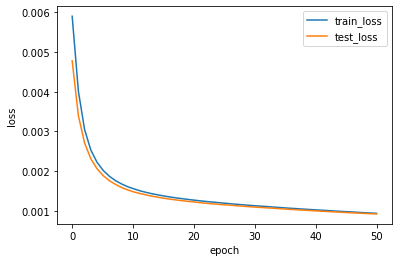

In [21]:
import matplotlib.pyplot as plt
import numpy as np
x=np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label='train_loss',linewidth=1.5)
plt.plot(x,test_loss,label='test_loss',linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()